In [16]:
import os
import glob
from collections import Counter
import calendar

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import xarray as xr
from scipy.stats import genextreme as gev
import xclim as xc
import numpy as np
import cartopy.crs as ccrs
import cmocean

from unseen import fileio
from unseen import indices

In [2]:
# Parameters
dpi = 300

In [3]:
# Parameters
rx15day_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
region_name = "east-coast-flood-region"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_HadISST_1870-2022_base-1981-2010.nc"

In [4]:
assert os.path.isfile(rx15day_file), "Must provide an rx15day file (papermill option -p rx15day_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a Nino 3.4 file (papermill option -p nino_file [filepath])"
assert 'region_name' in locals(), "Must provide a region name (papermill option -p region_name [name])"

## Analyse and plot Rx15day data

In [5]:
ds_rx15day = fileio.open_dataset(rx15day_file)
ds_rx15day = ds_rx15day.dropna('time')

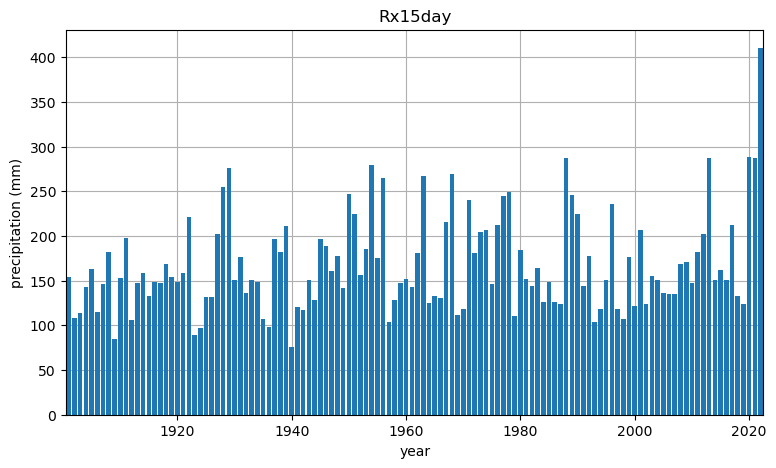

In [20]:
fig, ax = plt.subplots(figsize=[9, 5])
values = ds_rx15day['pr'].values
years = ds_rx15day['time'].dt.year.values
plt.bar(years, values, zorder=2)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('Rx15day')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.grid()
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

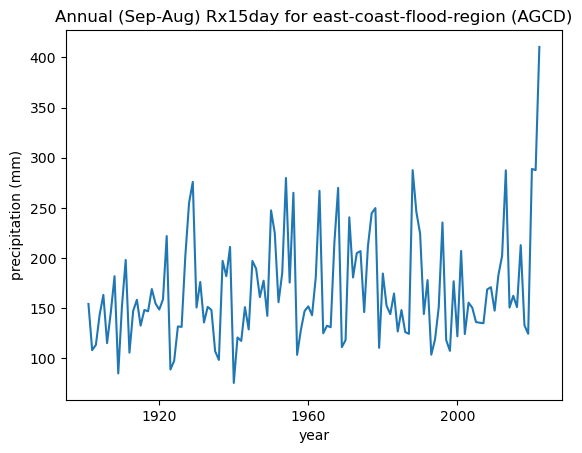

In [21]:
ds_rx15day['pr'].plot()
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} (AGCD)')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.show()

In [22]:
years = ds_rx15day['time'].dt.year.values
df_rx15day = pd.DataFrame(index=years)
df_rx15day['pr'] = ds_rx15day['pr'].values
df_rx15day['event_time'] = ds_rx15day['event_time'].values

In [23]:
df_rx15day

,pr,event_time
1901,154.216827,1901-03-21
1902,108.108200,1901-09-01
1903,113.448227,1903-06-03
1904,143.368881,1904-04-07
1905,163.224609,1905-04-06
...,...,...
2018,132.922501,2018-03-07
2019,124.441978,2018-10-19
2020,288.797943,2020-02-19
2021,287.605011,2021-03-24


In [24]:
ranked_events = df_rx15day.sort_values(['pr'], ascending=False)
ranked_events.head(n=10)

,pr,event_time
2022,410.430573,2022-03-09
2020,288.797943,2020-02-19
2021,287.605011,2021-03-24
1988,287.580750,1988-04-14
2013,287.379242,2013-03-04
1954,279.746857,1954-02-23
1929,275.875671,1929-02-20
1968,269.900574,1968-01-18
1963,267.014984,1963-05-09
1956,264.992493,1956-02-20


In [25]:
rx15day_max = df_rx15day['pr'].values.max()
print(rx15day_max)

410.43057


In [26]:
event_months = [int(date[5:7]) for date in ds_rx15day['event_time'].values]
event_years = [int(date[0:4]) for date in ds_rx15day['event_time'].values]

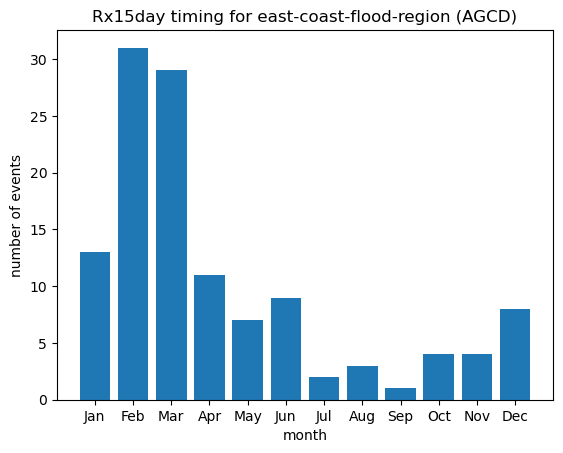

In [27]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} (AGCD)')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

In [28]:
nino34_ds = xr.open_dataset(nino_file)

In [29]:
event_nino34 = []
for month, year in zip(event_months, event_years):
    value = nino34_ds['sst'][(nino34_ds['time'].dt.month == month) & (nino34_ds['time'].dt.year == year)].values[0]
    event_nino34.append(value)
event_nino34 = np.array(event_nino34)

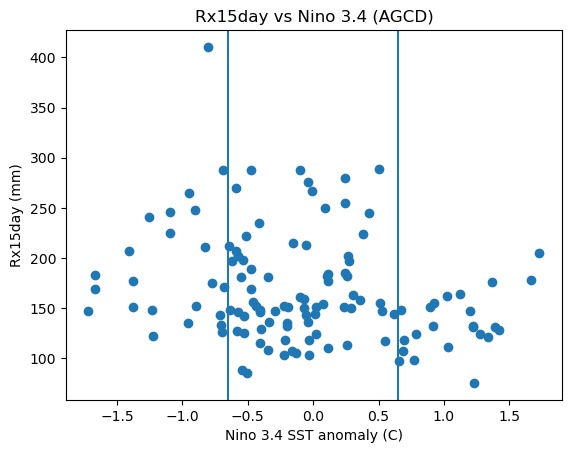

In [30]:
plt.scatter(event_nino34, ds_rx15day['pr'].values)
plt.title(f'Rx15day vs Nino 3.4 (AGCD)')
plt.ylabel('Rx15day (mm)')
plt.xlabel('Nino 3.4 SST anomaly (C)')
plt.axvline(0.65)
plt.axvline(-0.65)
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_ENSO_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=dpi
)
plt.show()

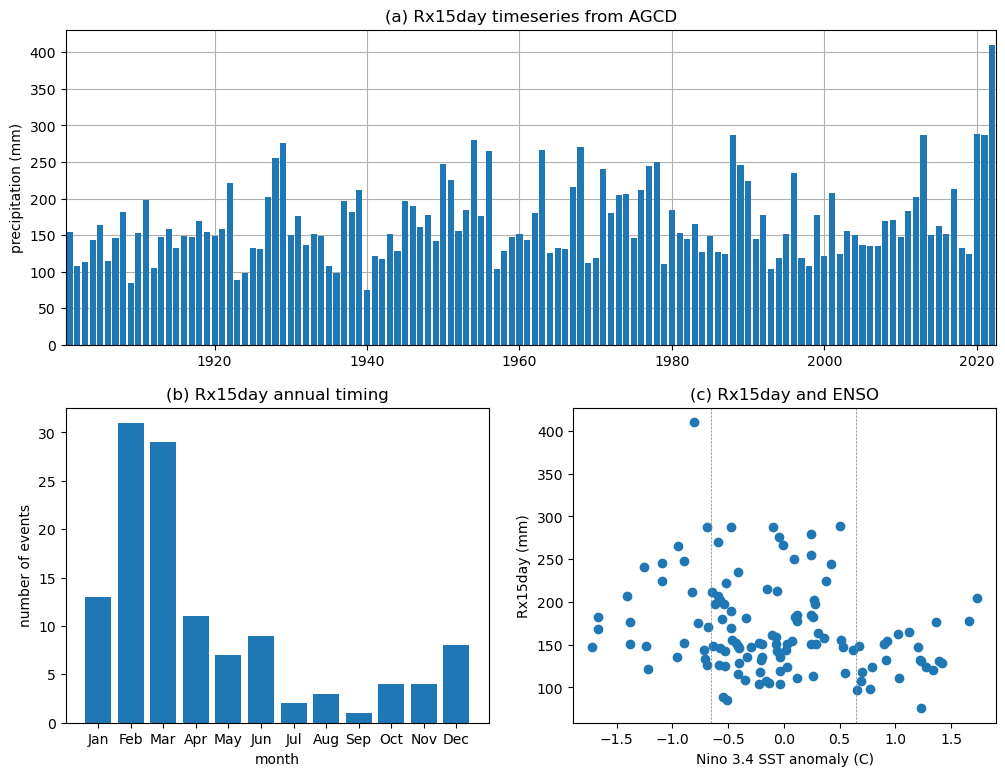

In [43]:
plt.figure(figsize=[12, 9])
gs = GridSpec(2, 2) #height_ratios=[3, 2])
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])

values = ds_rx15day['pr'].values
years = ds_rx15day['time'].dt.year.values
ax1.bar(years, values, zorder=2)
ax1.set_xlim(years[0] - 0.5, years[-1] + 0.5)
ax1.set_title('(a) Rx15day timeseries from AGCD')
ax1.set_ylabel('precipitation (mm)')
#ax1.set_xlabel('year')
ax1.grid()

ax2.bar(months, counts)
ax2.set_title(f'(b) Rx15day annual timing')
ax2.set_ylabel('number of events')
ax2.set_xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
ax2.set_xticks(months, xlabels)

ax3.scatter(event_nino34, ds_rx15day['pr'].values)
ax3.set_title('(c) Rx15day and ENSO')
ax3.set_ylabel('Rx15day (mm)')
ax3.set_xlabel('Nino 3.4 SST anomaly (C)')
ax3.axvline(0.65, color='0.5', linestyle='--', linewidth=0.5)
ax3.axvline(-0.65, color='0.5', linestyle='--', linewidth=0.5)

plt.savefig(
    '/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_AGCD_summary.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300,
)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=[9, 5])
values = ds_rx15day['pr'].values
years = ds_rx15day['time'].dt.year.values
plt.bar(years, values, zorder=2)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('Rx15day')
plt.ylabel('precipitation (mm)')
plt.xlabel('year')
plt.grid()
plt.savefig(
    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timeseries_AGCD_{region_name}.png',
    bbox_inches='tight',
    facecolor='white',
    dpi=300
)
plt.show()

In [15]:
def gev_analysis(ds, event, region, savefig=False):
    """Perform GEV analysis
    
    Args:
      ds (Pandas Series): Data sample
      event (float) : Event of interest
      region (str) : Name of spatial region
    """

    gev_shape, gev_loc, gev_scale = indices.fit_gev(ds.values)
    print(f'Shape parameter: {gev_shape:.2f}')
    print(f'Location parameter: {gev_loc:.2f}')
    print(f'Scale parameter: {gev_scale:.2f}')

    fig, ax = plt.subplots(figsize=[10, 8])
    gev_xvals = np.arange(0, 700)
    ds.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
    gev_pdf = gev.pdf(gev_xvals, gev_shape, gev_loc, gev_scale)
    plt.plot(gev_xvals, gev_pdf, color='tab:green', linewidth=4.0)
    plt.xlabel('precipitation (mm)')
    plt.ylabel('probability')
    plt.title(f'Annual (Sep-Aug) Rx15day for {region} (AGCD)')
    if savefig:
        plt.savefig(
            f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_AGCD_{region}.png',
            bbox_inches='tight',
            facecolor='white',
            dpi=dpi
        )
    plt.show()
    
    event_probability = gev.sf(event, gev_shape, loc=gev_loc, scale=gev_scale)
    event_return_period = 1. / event_probability
    event_percentile = (1 - event_probability) * 100
    print(f'{event_return_period:.0f} year return period\n')
    print(f'{event_percentile:.2f}% percentile')

Shape parameter: -0.06
Location parameter: 142.88
Scale parameter: 39.28


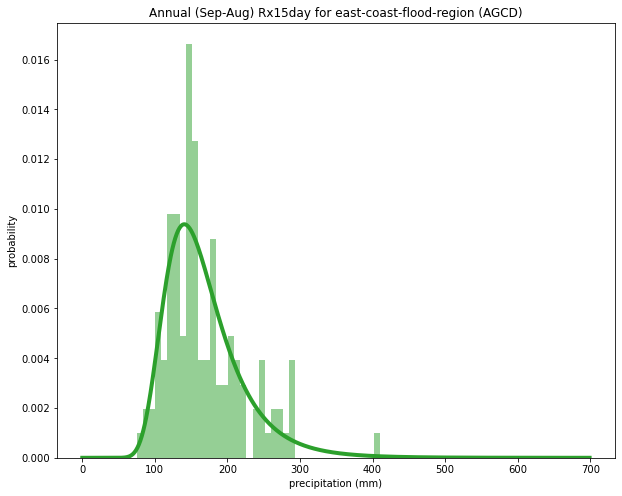

297 year return period

99.66% percentile


In [16]:
gev_analysis(df_rx15day['pr'], rx15day_max, region_name, savefig=True)

Shape parameter: -0.01
Location parameter: 143.11
Scale parameter: 38.74


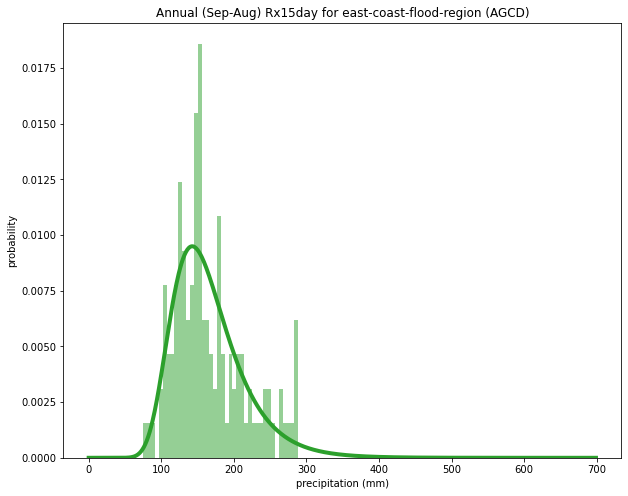

757 year return period

99.87% percentile


In [17]:
gev_analysis(df_rx15day['pr'][:-1], rx15day_max, region_name)

## Meteorology of the most extreme events

### 15-day aggregates

In [66]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    #plt.savefig(
    #    f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
    #    bbox_inches='tight',
    #    facecolor='white',
    #    dpi=300
    #)
    plt.show()

In [41]:
z500_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/zg500/zg500_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
z500_files.sort()

pr_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
pr_files.sort()

psl_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/psl/psl_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
psl_files.sort()

ua300_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/ua300/ua300_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
ua300_files.sort()

In [42]:
z500_ds = xr.open_mfdataset(z500_files)
pr_ds = xr.open_mfdataset(pr_files)
psl_ds = xr.open_mfdataset(psl_files)
ua300_ds = xr.open_mfdataset(ua300_files)

2022 (2022-03-09): 410.4305725097656mm


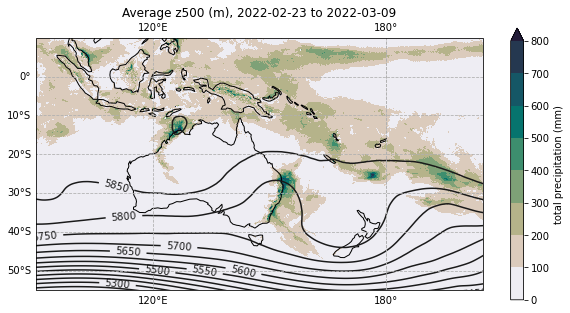

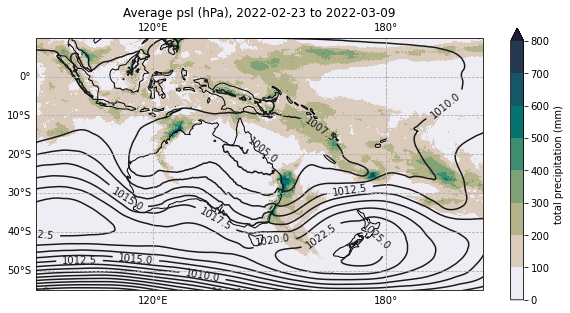

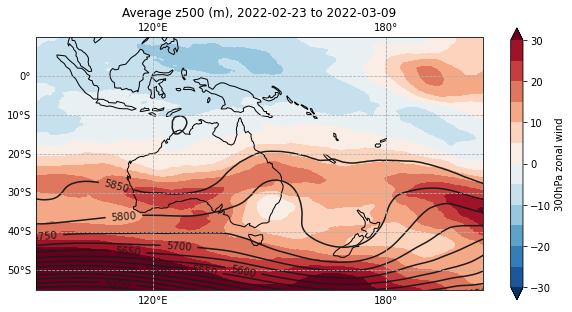

2020 (2020-02-19): 288.7979431152344mm


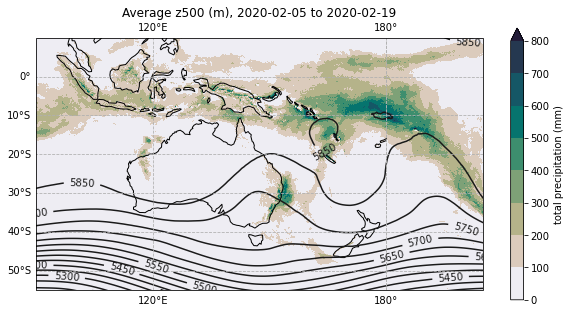

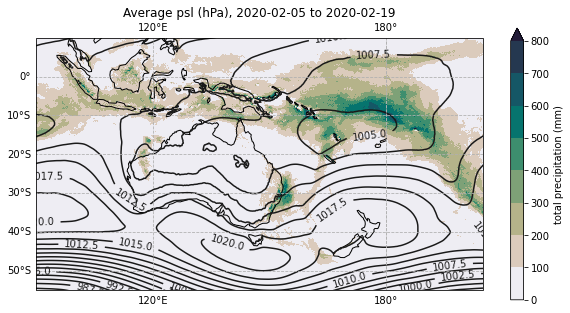

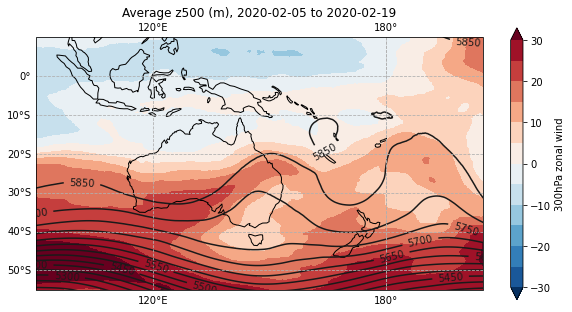

2021 (2021-03-24): 287.6050109863281mm


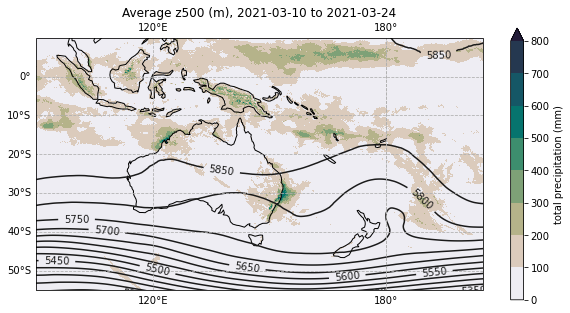

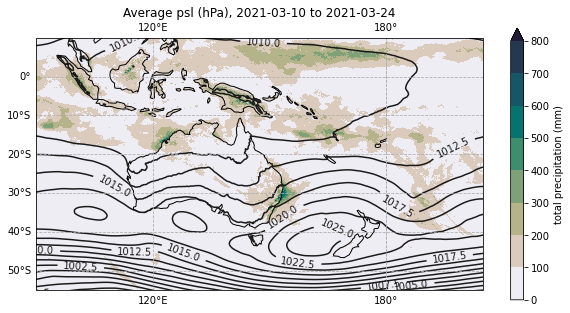

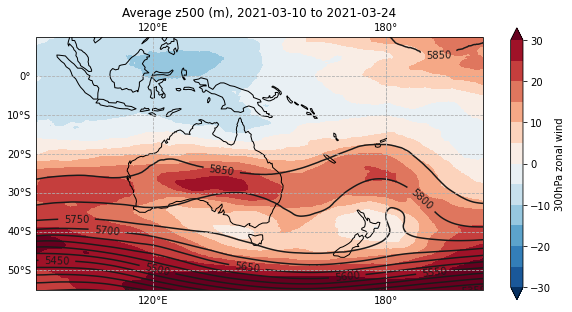

2013 (2013-03-04): 287.3792419433594mm


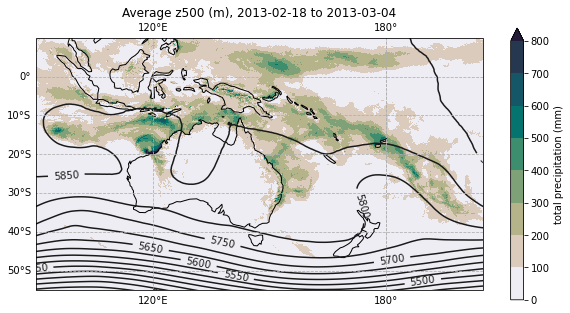

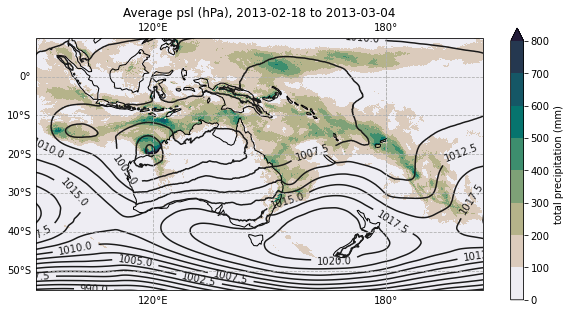

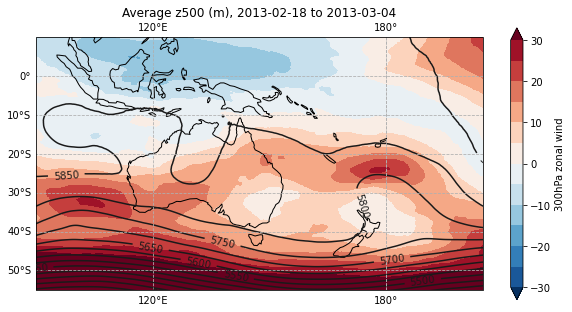

In [67]:
for index, row in ranked_events.head(n=5).iterrows():
    end_date = row['event_time']
    if int(end_date[0:4]) > 2007:
        rx_value = row['pr']
        print(f'{index} ({end_date}): {rx_value}mm')
        start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
        start_date = start_datetime.strftime("%Y-%m-%d")
        z500_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
        pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
        pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
        psl_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        psl_da = xc.units.convert_units_to(psl_da, 'hPa')
        ua300_da = ua300_ds.sel({'time': slice(start_date, end_date)})['ua300']

        z500_da_mean = z500_da.mean('time', keep_attrs=True)
        pr_da_sum = pr_da.sum('time', keep_attrs=True)
        psl_da_mean = psl_da.mean('time', keep_attrs=True)
        ua300_da_mean = ua300_da.mean('time', keep_attrs=True)    

        plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
        plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
        plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)

### Day-by-day

In [68]:
def plot_days(contour_var, start_date, end_date):
    """Plot days"""

    pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    
    if contour_var == 'z500':
        contour_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
    elif contour_var == 'psl':
        contour_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        contour_da = xc.units.convert_units_to(contour_da, 'hPa')
    else:
        raise ValueError('Invalid contour variable')
    
    fig = plt.figure(figsize=[20, 18])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 75)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 5)

    plot_order = [1, 4, 7, 10, 13, 2, 5, 8, 11, 14, 3, 6, 9, 12, 15]
    for day in range(15):
        ax = fig.add_subplot(5, 3, plot_order[day], projection=map_proj)
        pr_da.isel({'time': day}).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.rain,
            levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            extend='max',
            cbar_kwargs={'label': 'total precipitation (mm)'},
        )
    
        lines = contour_da.isel({'time': day}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        ax.coastlines()
        ax.gridlines(linestyle='--', draw_labels=True)
        date = str(pr_da.isel({'time': day})['time'].dt.strftime('%d %b').values)
        ax.set_title(date)
        ax.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    plt.suptitle(f'Daily {contour_var} ({contour_da.units})')
#    plt.savefig(
#        f'{contour_var}_days_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

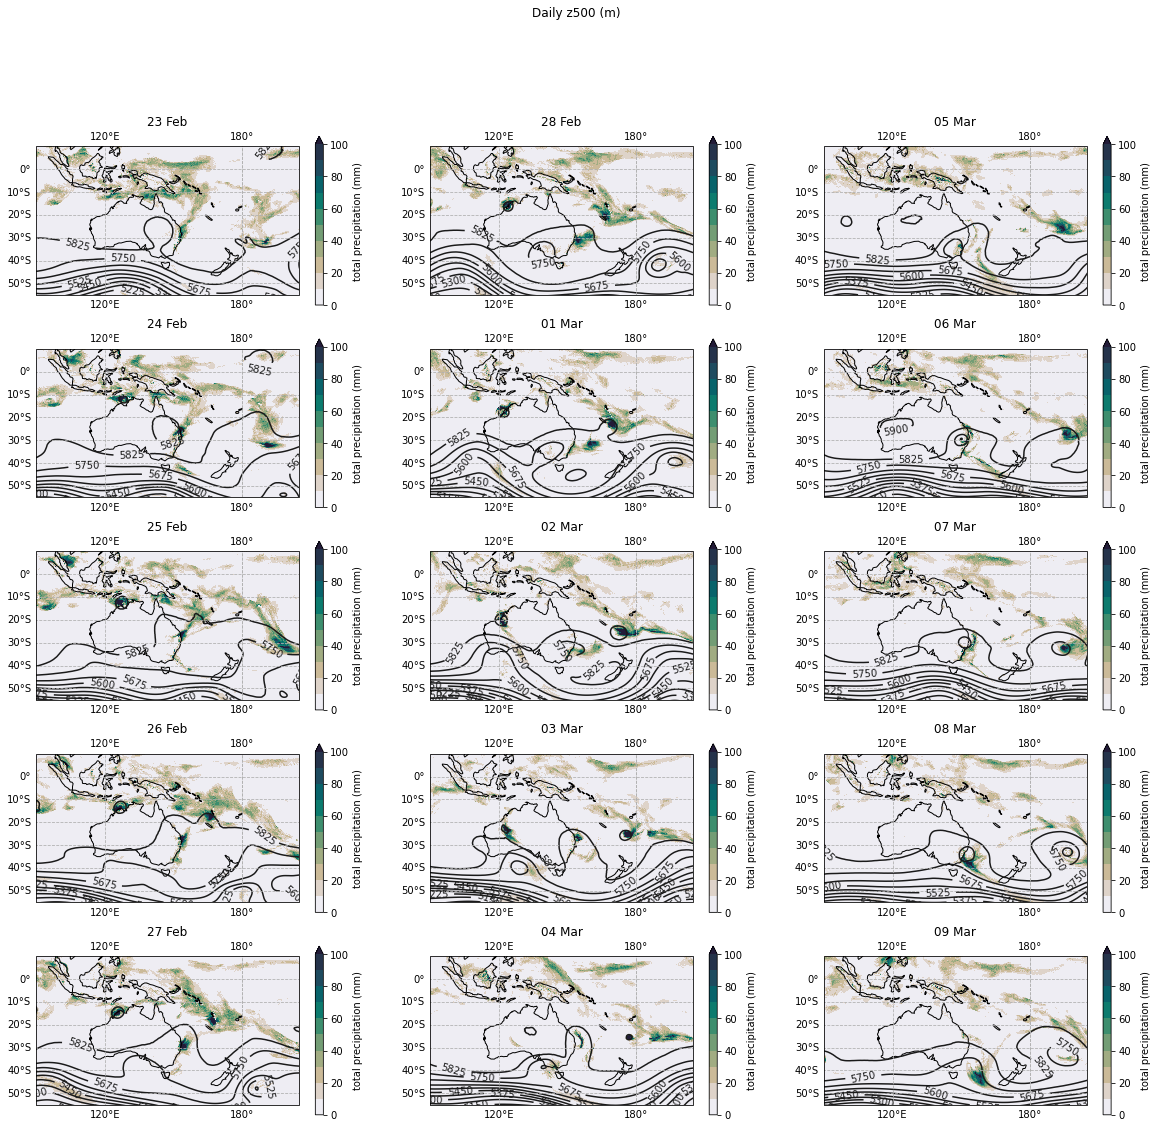

In [69]:
plot_days('z500', '2022-02-23', '2022-03-09')

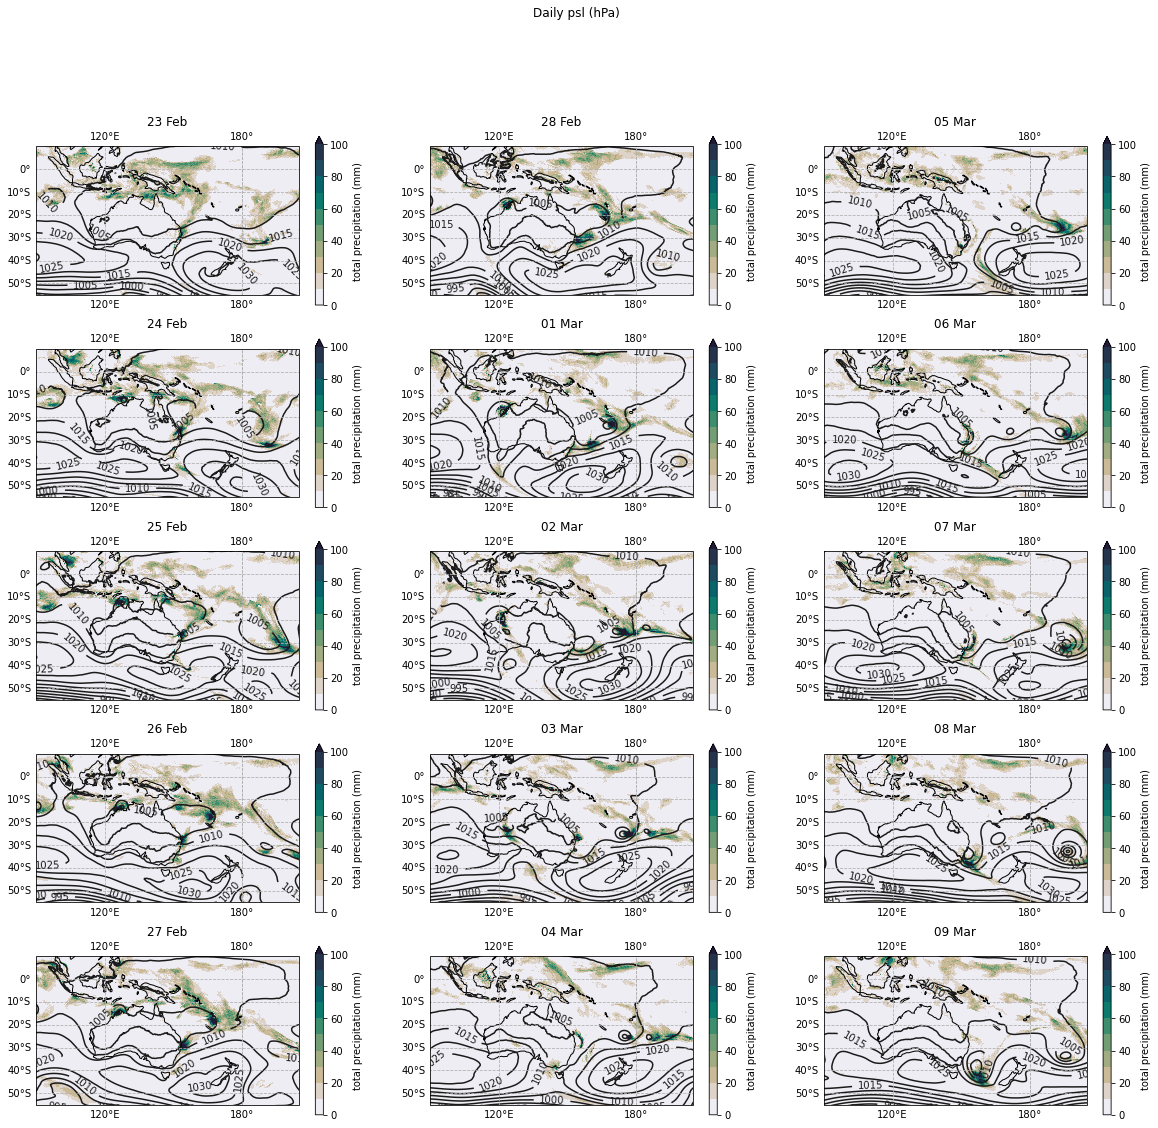

In [70]:
plot_days('psl', '2022-02-23', '2022-03-09')